In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

df= pd.read_excel('sensor_data3.xlsx')  

## Özet

* CO2 korelasyonlarını inceledim. HumidityRatio korelasyanu çok olduğu için, ek özellik olarak 750 periyotlu RSI indikatörüne girmiş HumidityRatio'dan, rsi_HumidityRatio_750 kolonunu elde ettim. Yüksek koreleli bir özellik daha kazanmış oldum
*
* Gereksiz oluşan sütunları dropladıktan sonra %80 e %20 ayırdığım veri setimi eğittim.
*
* Sizin istediğiniz bir sonraki değer (Actual Value) 478.0 iken  ben (Predicted Value) 471.030517578125 tahmin ettim.
*
* %20lik eğitim setinde r2 skoru ise 0.9043599336586803
*
* Geleceğe dair Temperature, Humidity, Light, HumidityRatio, Occupancy değerlerini tahminlerine (meteoroloji tahminlerine) göre bundan sonra ki  gelecek CO2 değerlerini tahmin edebiliriz. 
 



In [2]:
df.head()

,ID,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,140,2.02.2015 14:19,23.7000,26.272,585.200000,749.200000,0.004764,1
1,141,2.02.2015 14:19,23.7180,26.290,578.400000,760.400000,0.004773,1
2,142,2.02.2015 14:21,23.7300,26.230,572.666667,769.666667,0.004765,1
3,143,2.02.2015 14:22,23.7225,26.125,493.750000,774.750000,0.004744,1
4,144,2.02.2015 14:23,23.7540,26.200,488.600000,779.000000,0.004767,1


In [3]:
df.info() # eksik veri kontrol

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             2665 non-null   int64  
 1   date           2665 non-null   object 
 2   Temperature    2665 non-null   float64
 3   Humidity       2665 non-null   float64
 4   Light          2665 non-null   float64
 5   CO2            2665 non-null   float64
 6   HumidityRatio  2665 non-null   float64
 7   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 166.7+ KB


In [4]:
df.corr(method ='kendall')

,ID,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
ID,1.000000,-0.129836,0.126336,0.009064,-0.016860,0.040535,-0.019483
Temperature,-0.129836,1.000000,0.602086,0.561529,0.765439,0.749252,0.542966
Humidity,0.126336,0.602086,1.000000,0.457272,0.756236,0.855223,0.509022
Light,0.009064,0.561529,0.457272,1.000000,0.572656,0.515911,0.841183
CO2,-0.016860,0.765439,0.756236,0.572656,1.000000,0.846367,0.602233
HumidityRatio,0.040535,0.749252,0.855223,0.515911,0.846367,1.000000,0.552261
Occupancy,-0.019483,0.542966,0.509022,0.841183,0.602233,0.552261,1.000000


In [5]:
# RSI hesaplama

n = 750 #en optimum periyot değeri
def rma(x, n, y0):
    a = (n-1) / n
    ak = a**np.arange(len(x)-1, -1, -1)
    return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]

df['change'] = df['HumidityRatio'].diff()
df['gain'] = df.change.mask(df.change < 0, 0.0)
df['loss'] = -df.change.mask(df.change > 0, -0.0)
df['avg_gain'] = rma(df.gain[n+1:].to_numpy(), n, np.nansum(df.gain.to_numpy()[:n+1])/n)
df['avg_loss'] = rma(df.loss[n+1:].to_numpy(), n, np.nansum(df.loss.to_numpy()[:n+1])/n)
df['rs'] = df.avg_gain / df.avg_loss
df['rsi_HumidityRatio_750'] = 100 - (100 / (1 + df.rs))

In [6]:
df.corr(method ='kendall')

,ID,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,change,gain,loss,avg_gain,avg_loss,rs,rsi_HumidityRatio_750
ID,1.000000,-0.129836,0.126336,0.009064,-0.016860,0.040535,-0.019483,0.043405,0.018391,-0.053224,-0.070966,-0.370545,0.067201,0.067225
Temperature,-0.129836,1.000000,0.602086,0.561529,0.765439,0.749252,0.542966,0.013703,0.115672,0.082642,0.775576,-0.309330,0.781232,0.781338
Humidity,0.126336,0.602086,1.000000,0.457272,0.756236,0.855223,0.509022,0.015602,0.091598,0.056633,0.777783,-0.281212,0.790560,0.790666
Light,0.009064,0.561529,0.457272,1.000000,0.572656,0.515911,0.841183,0.141046,0.249500,-0.014246,0.431744,-0.492495,0.543756,0.543830
CO2,-0.016860,0.765439,0.756236,0.572656,1.000000,0.846367,0.602233,0.018200,0.120511,0.077842,0.773691,-0.355425,0.839695,0.839825
HumidityRatio,0.040535,0.749252,0.855223,0.515911,0.846367,1.000000,0.552261,0.019252,0.111124,0.067610,0.838654,-0.315980,0.850491,0.850606
Occupancy,-0.019483,0.542966,0.509022,0.841183,0.602233,0.552261,1.000000,0.158058,0.274039,-0.024873,0.458567,-0.507898,0.572009,0.572085
change,0.043405,0.013703,0.015602,0.141046,0.018200,0.019252,0.158058,1.000000,0.801303,-0.808208,0.001038,-0.105934,0.048119,0.048119
gain,0.018391,0.115672,0.091598,0.249500,0.120511,0.111124,0.274039,0.801303,1.000000,-0.455959,0.086411,-0.167391,0.138346,0.138361
loss,-0.053224,0.082642,0.056633,-0.014246,0.077842,0.067610,-0.024873,-0.808208,-0.455959,1.000000,0.089383,0.022289,0.054357,0.054370


**RSI hesaplayarak ek özellik eklemek istedim. Korelasyonu çok yüksek olan "HumidityRatio" özelliğini kullandım. Görüldüğü üzere "rsi_HumidityRatio_750" korelasyonu CO2 ile yüksek korelasyona sahip.**

## model

In [7]:
df = df[["Temperature" , "Humidity", "Light" , "CO2" , "HumidityRatio"  ,"rsi_HumidityRatio_750"]]

In [8]:
df.head()

df = df.iloc[750: , :]

#ilk 750 satırı dropladım. çünkü RSI periyodumuz 750. ilk rsi_HumidityRatio_750 satırı NaN değere sahip.

In [9]:
df.corr(method ='kendall') 

,Temperature,Humidity,Light,CO2,HumidityRatio,rsi_HumidityRatio_750
Temperature,1.000000,0.723576,0.573890,0.796372,0.840873,0.781338
Humidity,0.723576,1.000000,0.368346,0.805648,0.884602,0.790666
Light,0.573890,0.368346,1.000000,0.539869,0.463410,0.543830
CO2,0.796372,0.805648,0.539869,1.000000,0.868683,0.839825
HumidityRatio,0.840873,0.884602,0.463410,0.868683,1.000000,0.850606
rsi_HumidityRatio_750,0.781338,0.790666,0.543830,0.839825,0.850606,1.000000


In [10]:
x_train = df.iloc[0:1532 , :] # %80 train için ayrıldı
x_test = df.iloc[1532: , :]

In [11]:
y_train=x_train[["CO2"]]
x_train.drop(["CO2"],axis=1,inplace=True)


y_test=x_test[["CO2"]]
x_test.drop(["CO2"],axis=1,inplace=True)

/home/hakan/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
x_train.head()

,Temperature,Humidity,Light,HumidityRatio,rsi_HumidityRatio_750
750,20.5,22.315000,0.0,0.003322,38.170687
751,20.5,22.315000,0.0,0.003322,38.170687
752,20.5,22.356667,0.0,0.003328,38.234037
753,20.5,22.390000,0.0,0.003333,38.284683
754,20.5,22.390000,0.0,0.003333,38.284683


In [13]:
model = XGBRegressor()

xgb_search = model.fit(x_train, y_train)
y_pred = model.predict(x_test)



In [14]:
# y_pred series çevirme

my_list = map(lambda x: x, y_pred)
y_pred = pd.Series(my_list)

In [15]:
print("%20'lik tahminde r2 skoru : ",r2_score(y_test, y_pred))
print("Predicted Value : " , y_pred[0]) 
print("Actual Value : : " , y_test["CO2"][0 : 1])

# bir sonraki adımda 7 birimlik bir sapma var
# %20'lik r2 skoru 0.90 

%20'lik tahminde r2 skoru :  0.9043599336586803
Predicted Value :  471.030517578125
Actual Value : :  2282    478.0
Name: CO2, dtype: float64


<AxesSubplot:title={'center':'Gerçek Değerler'}>

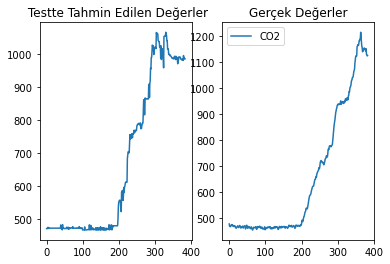

In [16]:
from matplotlib import pyplot as plt

y_test = y_test.reset_index()
y_test = y_test[["CO2"]]
fig, axs = plt.subplots(1,2)

y_pred.plot(ax=axs[0] , title = " Testte Tahmin Edilen Değerler")
y_test.plot(ax=axs[1] , title ="Gerçek Değerler" )